In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('notebook')
sns.set_style('darkgrid')

---
# Classifying handwritten digits

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_digits_classification_001.png)

<br>

<big>

## Load the data

---

- There are 1797 images of handwritten digits of 8x8 pixels each    
- The dataset has 1797 rows and 64 columns
    - Each row is an image, each column is a pixel

<br>

In [2]:
from sklearn import datasets
digits = datasets.load_digits()

print(digits.keys())
print(digits.images.shape)
print(digits.data.shape)

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
(1797, 8, 8)
(1797, 64)


In [10]:
pd.DataFrame(digits.data, index=[f"Digit{i}" for i in range(1797)], columns=[f"Pixel{i}" for i in range(64)]).assign(prediction='?').assign(actual=digits.target)

,Pixel0,Pixel1,Pixel2,Pixel3,Pixel4,Pixel5,Pixel6,Pixel7,Pixel8,Pixel9,...,Pixel56,Pixel57,Pixel58,Pixel59,Pixel60,Pixel61,Pixel62,Pixel63,prediction,actual
Digit0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,?,0
Digit1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,?,1
Digit2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,?,2
Digit3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,?,3
Digit4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,?,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Digit1792,0.0,0.0,4.0,10.0,13.0,6.0,0.0,0.0,0.0,1.0,...,0.0,0.0,2.0,14.0,15.0,9.0,0.0,0.0,?,9
Digit1793,0.0,0.0,6.0,16.0,13.0,11.0,1.0,0.0,0.0,0.0,...,0.0,0.0,6.0,16.0,14.0,6.0,0.0,0.0,?,0
Digit1794,0.0,0.0,1.0,11.0,15.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,9.0,13.0,6.0,0.0,0.0,?,8
Digit1795,0.0,0.0,2.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,12.0,16.0,12.0,0.0,0.0,?,9


<br>

<big>

---
## Inspect the data

- An 8x8 pixel image can be displayed using matplotlib's `imshow`

<br>

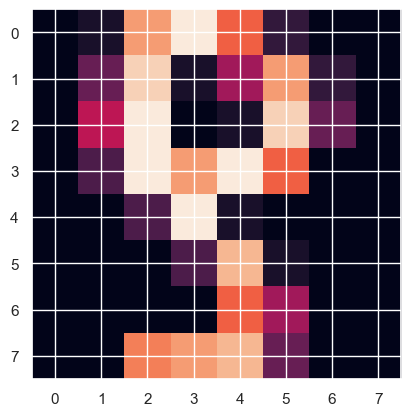

In [16]:
plt.imshow(digits.images[1100]);

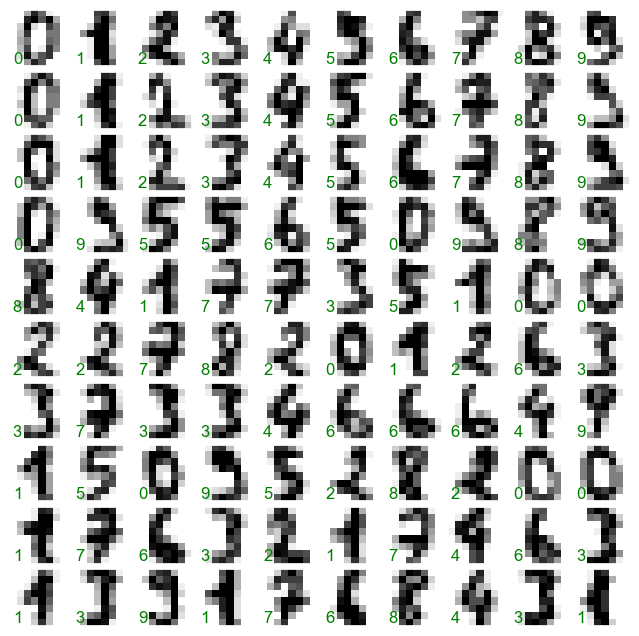

In [17]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary')
    ax.text(0.05, 0.05, str(digits.target[i]),
            transform=ax.transAxes, color='green')
    ax.set_xticks([])
    ax.set_yticks([])

In [18]:
digits_df = pd.DataFrame(digits.data, 
                         columns=["Pixel_" + str(i) for i in range(64)])

In [19]:
digits_df[:5]

,Pixel_0,Pixel_1,Pixel_2,Pixel_3,Pixel_4,Pixel_5,Pixel_6,Pixel_7,Pixel_8,Pixel_9,...,Pixel_54,Pixel_55,Pixel_56,Pixel_57,Pixel_58,Pixel_59,Pixel_60,Pixel_61,Pixel_62,Pixel_63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


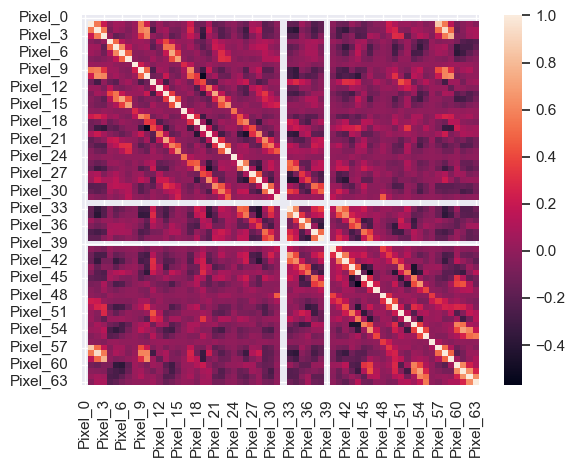

In [20]:
sns.heatmap(digits_df.corr());

<br>

<big>

## Let's build a model

In [22]:
# Step 1: Import a model Class
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

In [ ]:
SVC()

In [21]:
# The Dependent Variable
import numpy as np
np.unique(digits.target)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

<br>

<big>
    
## This is a Multiclass Classification Problem since the Dependent Variable has 10 classes

<br>

## Step 1: Visualize the Classification Boundary using PCA
---

<br>

In [24]:
# {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}

from sklearn.preprocessing import StandardScaler
X_digits = StandardScaler().fit_transform(digits.data)

In [25]:
from sklearn.decomposition import PCA

pca_2 = PCA(n_components=2)
data_2comp = pca_2.fit_transform(X_digits)

In [26]:
data_2comp

array([[-1.91421366, -0.95450157],
       [-0.58898033,  0.9246358 ],
       [-1.30203906, -0.31718883],
       ...,
       [-1.02259599, -0.14791087],
       [-1.07605522, -0.38090625],
       [ 1.25770233, -2.22759088]], shape=(1797, 2))

In [27]:
evr = pca_2.explained_variance_ratio_.sum()
print(f"The Explained Variance is: {evr:.1%}")

The Explained Variance is: 21.6%


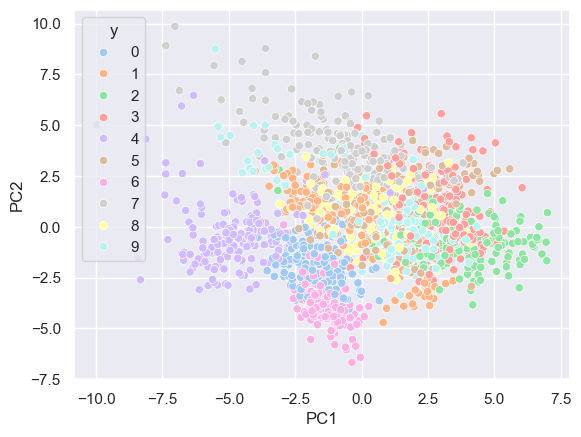

In [36]:
sns.scatterplot(
    data=pd.DataFrame(data=data_2comp, columns=['PC1', 'PC2']).assign(y=digits.target),
    x='PC1',
    y='PC2',
    hue='y',
    palette='pastel'
);

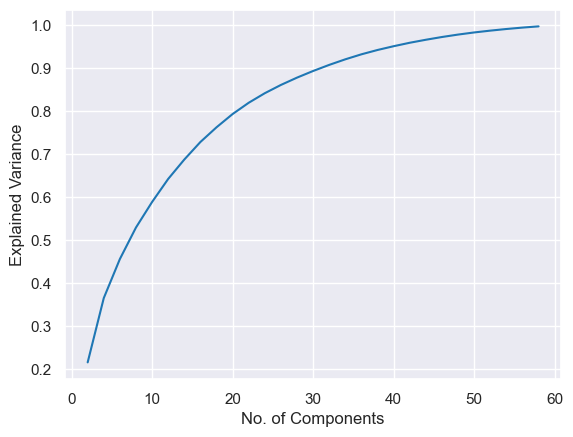

In [39]:
ax = pd.Series({n:PCA(n_components=n).fit(X_digits).explained_variance_ratio_.sum() for n in range(2, 60, 2)}, name='Explained Variance').plot()
ax.set_xlabel("No. of Components")
ax.set_ylabel("Explained Variance");

In [40]:
# Selecting the 25 component solution that explains 85% of the variance.
X_pca = PCA(n_components=25).fit_transform(X_digits)

In [41]:
pd.DataFrame(X_pca).shape

(1797, 25)

---

## Dimensionality Reduction with `Isomap`

- We'd like to visualize our points within the **64-dimensional parameter space**, but it's difficult to plot points in 64 dimensions!

- Instead we'll reduce the dimensions to 2, using an unsupervised method.

- Here, we'll make use of a **manifold learning algorithm** called *Isomap*, and transform the data to two dimensions.

- This is a critical step because it will lead to the selection of a few candidate algorithms that would possess the ability to discover the classfication boundary for this data.

In [42]:
from sklearn.manifold import Isomap, TSNE

In [43]:
iso = Isomap(n_components=2, n_neighbors=10)
data_projected = iso.fit_transform(digits.data)
data_projected.shape

(1797, 2)

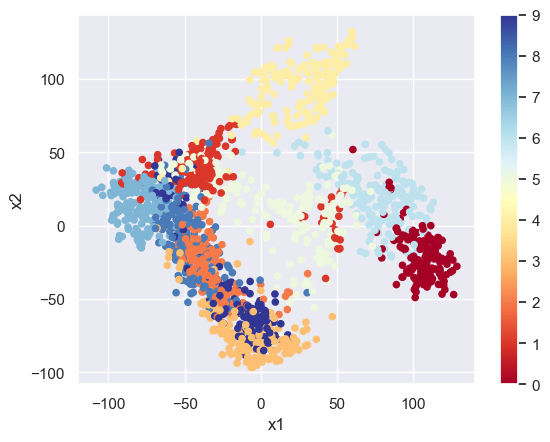

In [44]:
# Visualize the data in 2 dimensions

(pd.DataFrame(data_projected, columns=['x1', 'x2'])
 .plot
 .scatter(x='x1', y='x2', 
          c=digits.target, 
          cmap='RdYlBu'));

## TSNE

In [45]:
tsne = TSNE(n_components=2)
data_projected = tsne.fit_transform(digits.data)
data_projected.shape

(1797, 2)

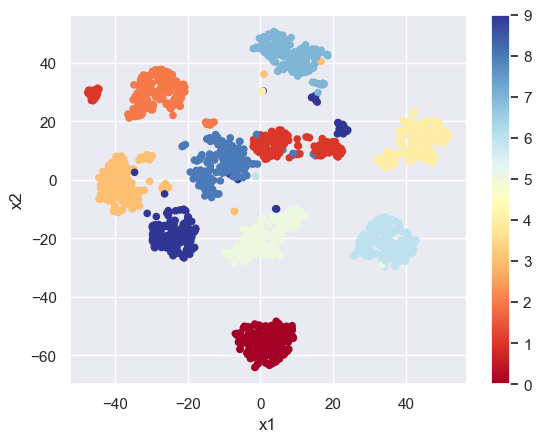

In [46]:
# Visualize the data in 2 dimensions
(pd.DataFrame(data_projected, columns=['x1', 'x2'])
 .plot
 .scatter(x='x1', y='x2', 
          c=digits.target, 
          cmap='RdYlBu'));

<br>

<big>

We see here that the digits are fairly well-separated in the parameter space; this tells us that a **non-linear** supervised classification algorithm should perform fairly well. 
Let's give it a try.

---

In [65]:
# Data Splitting

from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(digits.data, 
                                                digits.target, 
                                                train_size=0.75)

---
### `Logistic Regression` with Default Hyperparameters

In [66]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

In [67]:
clf = LogisticRegression(max_iter=300)
clf.fit(Xtrain, Ytrain)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,300
,multi_class,'deprecated'


In [68]:
# Training Accuracy
round(accuracy_score(Ytrain, clf.predict(Xtrain)), 3)

1.0

In [69]:
# Test Accuracy
round(accuracy_score(Ytest, clf.predict(Xtest)), 3)

0.971

In [77]:
pd.Series(data=cross_val_score(clf, Xtest, Ytest, scoring='accuracy', cv=10)).describe()

count    10.000000
mean      0.948889
std       0.031514
min       0.911111
25%       0.916667
50%       0.955556
75%       0.972222
max       1.000000
dtype: float64

## Visualize the Confusion Matrix

In [78]:
pd.DataFrame(data=confusion_matrix(Ytest, clf.predict(Xtest)), index=[f"Actual_{x}" for x in range(10)], columns=[f"Predicted_{x}" for x in range(10)])

,Predicted_0,Predicted_1,Predicted_2,Predicted_3,Predicted_4,Predicted_5,Predicted_6,Predicted_7,Predicted_8,Predicted_9
Actual_0,37,0,0,0,0,0,0,0,0,0
Actual_1,0,46,0,0,0,0,0,0,3,1
Actual_2,0,0,47,0,0,0,0,0,0,0
Actual_3,0,0,1,38,0,0,0,0,0,1
Actual_4,0,0,0,0,45,0,0,0,0,0
Actual_5,0,1,0,0,0,46,0,0,0,1
Actual_6,0,0,0,0,0,0,50,0,0,0
Actual_7,0,0,0,0,0,0,0,51,0,1
Actual_8,0,1,1,0,0,1,0,0,35,0
Actual_9,0,0,0,0,0,0,0,1,0,42


> Binary Classfication Problem: Performance Metrics on the Confusion Matrix

- http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/
- https://en.wikipedia.org/wiki/Confusion_matrix

In [79]:
print(classification_report(Ytest, clf.predict(Xtest)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.96      0.92      0.94        50
           2       0.96      1.00      0.98        47
           3       1.00      0.95      0.97        40
           4       1.00      1.00      1.00        45
           5       0.98      0.96      0.97        48
           6       1.00      1.00      1.00        50
           7       0.98      0.98      0.98        52
           8       0.92      0.92      0.92        38
           9       0.91      0.98      0.94        43

    accuracy                           0.97       450
   macro avg       0.97      0.97      0.97       450
weighted avg       0.97      0.97      0.97       450



---
## Task 2

RE RUN THE DIGITS CLASSIFICATION USING SVM and report the accuracy for different settings of the `kernel` parameter.
'linear', 'rbf', 'poly'

---

In [80]:
for K in ['linear', 'poly', 'rbf', 'sigmoid']:
    """
    """
    clf = SVC(kernel = K)
    clf.fit(Xtrain, Ytrain)
    print('For Kernel: ', K, ' the accuracy is: ', cross_val_score(clf, Xtest, Ytest, cv=10, scoring='accuracy').mean())

For Kernel:  linear  the accuracy is:  0.968888888888889
For Kernel:  poly  the accuracy is:  0.9777777777777779
For Kernel:  rbf  the accuracy is:  0.9644444444444445
For Kernel:  sigmoid  the accuracy is:  0.9111111111111111


In [81]:
from sklearn.neighbors import KNeighborsClassifier

for n in range(5, 26, 5):
    knn_obj = KNeighborsClassifier(n_neighbors=n)
    knn_obj.fit(Xtrain, Ytrain)
    ypred = knn_obj.predict(Xtest)
    print('For {} neighbors, the accuracy is: {}'.format(n, 
                                                       accuracy_score(Ytest, ypred)))

For 5 neighbors, the accuracy is: 0.9888888888888889
For 10 neighbors, the accuracy is: 0.9888888888888889
For 15 neighbors, the accuracy is: 0.9822222222222222
For 20 neighbors, the accuracy is: 0.9755555555555555
For 25 neighbors, the accuracy is: 0.9755555555555555


---
## Using GridSearchCV

In [82]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [83]:
# Set the parameters by cross-validation
par_grid = {'kernel': ['poly', 'linear'], 
            'gamma': [1e-3, 1e-4], 
            'C': [1, 10, 100, 1000]}

gscv_svc = GridSearchCV(estimator=SVC(), 
                        param_grid=par_grid, 
                        cv=5, 
                        scoring='accuracy', 
                        verbose=True)

gscv_svc.fit(Xtrain, Ytrain)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,estimator,SVC()
,param_grid,"{'C': [1, 10, ...], 'gamma': [0.001, 0.0001], 'kernel': ['poly', 'linear']}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,True
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,100


In [84]:
pd.DataFrame(gscv_svc.cv_results_).set_index('params').loc[:, 'mean_test_score':]

,mean_test_score,std_test_score,rank_test_score
params,,,
"{'C': 1, 'gamma': 0.001, 'kernel': 'poly'}",0.985904,0.006779,2
"{'C': 1, 'gamma': 0.001, 'kernel': 'linear'}",0.979232,0.011836,7
"{'C': 1, 'gamma': 0.0001, 'kernel': 'poly'}",0.916899,0.033217,16
"{'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}",0.979232,0.011836,7
"{'C': 10, 'gamma': 0.001, 'kernel': 'poly'}",0.985904,0.006779,2
"{'C': 10, 'gamma': 0.001, 'kernel': 'linear'}",0.979232,0.011836,7
"{'C': 10, 'gamma': 0.0001, 'kernel': 'poly'}",0.976998,0.012707,15
"{'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}",0.979232,0.011836,7
"{'C': 100, 'gamma': 0.001, 'kernel': 'poly'}",0.985904,0.006779,2


In [85]:
gscv_svc.best_params_

{'C': 100, 'gamma': 0.0001, 'kernel': 'poly'}

In [86]:
gscv_svc.best_score_

np.float64(0.9866473908853092)

In [87]:
gscv_svc.best_estimator_

,C,100
,kernel,'poly'
,degree,3
,gamma,0.0001
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [88]:
print(classification_report(Ytest, gscv_svc.best_estimator_.predict(Xtest)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        50
           2       0.98      1.00      0.99        47
           3       1.00      0.97      0.99        40
           4       1.00      1.00      1.00        45
           5       1.00      0.96      0.98        48
           6       1.00      1.00      1.00        50
           7       1.00      1.00      1.00        52
           8       1.00      0.97      0.99        38
           9       0.93      1.00      0.97        43

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450



In [90]:
pd.DataFrame(data=confusion_matrix(Ytest, gscv_svc.best_estimator_.predict(Xtest)), index=[f"Actual_{x}" for x in range(10)], columns=[f"Predicted_{x}" for x in range(10)])

,Predicted_0,Predicted_1,Predicted_2,Predicted_3,Predicted_4,Predicted_5,Predicted_6,Predicted_7,Predicted_8,Predicted_9
Actual_0,37,0,0,0,0,0,0,0,0,0
Actual_1,0,50,0,0,0,0,0,0,0,0
Actual_2,0,0,47,0,0,0,0,0,0,0
Actual_3,0,0,1,39,0,0,0,0,0,0
Actual_4,0,0,0,0,45,0,0,0,0,0
Actual_5,0,0,0,0,0,46,0,0,0,2
Actual_6,0,0,0,0,0,0,50,0,0,0
Actual_7,0,0,0,0,0,0,0,52,0,0
Actual_8,0,0,0,0,0,0,0,0,37,1
Actual_9,0,0,0,0,0,0,0,0,0,43


In [ ]:
accuracy_score(Ytrain, gscv_svc.best_estimator_.predict(Xtrain))

# An underfitted model would have a LOW TRAINING ACCURACY
# Therefore, our best model as found by GSCV is a good model that doesn't underfit.

In [ ]:
accuracy_score(Ytest, gscv_svc.best_estimator_.predict(Xtest))

# An overfitted model would have much LOWER TEST ACCURACY as compared with TRAIN ACCURACY
# Here, we see that both Train and Test accuracy is high
# So our model is not Overfitting.

## Diamonds Data
---


> Can we predict the price of a diamond?

In [91]:
df_diamonds = sns.load_dataset('diamonds')

In [93]:
# Dependent Variable
y = df_diamonds['price']

In [114]:
# Independent Variables: Preprocessing
X = \
pd.concat([
    # Numeric data: Standardize
    (df_diamonds
        .drop(columns='price')
        .select_dtypes(include=np.number)
        .apply(lambda col: col.subtract(col.mean()).divide(col.std()))
    ),    
    # Non-numeric data: Make dummies
    (pd.concat([
        pd.get_dummies(df_diamonds[col], 
                       prefix=col, 
                       drop_first=True) 
        for col 
        in ['cut', 'color', 'clarity']
    ], axis=1).astype(int))
], axis=1)

In [115]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.75, random_state=1123)

In [116]:
# Step 1: Import Model Class
from sklearn.linear_model import LinearRegression

In [117]:
# Step 2: Create model object
model_object = LinearRegression()

In [118]:
# Step 3: Use fit method of model_object and give it the training data
model_object.fit(X_tr, y_tr)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [124]:
# Step 4: Use fitted model object to make prediction with test data
y_pr = model_object.predict(X_te)

In [131]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [133]:
mean_absolute_percentage_error(y_te, y_pr)

0.3869096382950477

## Decision Tree

In [134]:
from sklearn.tree import DecisionTreeRegressor

In [135]:
# created the model object
tree = DecisionTreeRegressor()

In [136]:
# fit the model
tree.fit(X_tr, y_tr)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [138]:
y_pr_tree = tree.predict(X_te)

In [159]:
# TRAINING ERROR IS SUPER LOW
mean_absolute_percentage_error(y_tr, tree.predict(X_tr))

0.00016848730387040786

In [160]:
# TEST ERROR IS LOW vs. Linear Model BUT very high compared with TRAINING ERROR
mean_absolute_percentage_error(y_te, y_pr_tree)

0.08921208783131823

## Optimize the Hyperparameters

In [143]:
tree_grid = {
    'max_depth': [4, 8, 12],
    'min_samples_leaf': [50, 100, 250]
}

In [144]:
from sklearn.model_selection import GridSearchCV

In [156]:
tree_gscv = GridSearchCV(
    estimator=DecisionTreeRegressor(), # which model to optimize
    param_grid=tree_grid,              # the search space to find the best combination of values
    scoring='neg_mean_absolute_percentage_error',  # which metric to use to find the best combo
    cv=10                               # how many times to repeat the process to avoid one-split results
)

In [157]:
tree_gscv.fit(X_tr, y_tr)

,estimator,DecisionTreeRegressor()
,param_grid,"{'max_depth': [4, 8, ...], 'min_samples_leaf': [50, 100, ...]}"
,scoring,'neg_mean_absolute_percentage_error'
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'squared_error'


In [158]:
pd.DataFrame(tree_gscv.cv_results_).set_index('params').loc[:, 'mean_test_score':].sort_values('rank_test_score')

,mean_test_score,std_test_score,rank_test_score
params,,,
"{'max_depth': 12, 'min_samples_leaf': 50}",-0.113907,0.002392,1
"{'max_depth': 12, 'min_samples_leaf': 100}",-0.131011,0.003082,2
"{'max_depth': 8, 'min_samples_leaf': 50}",-0.136952,0.002398,3
"{'max_depth': 8, 'min_samples_leaf': 100}",-0.143571,0.003159,4
"{'max_depth': 12, 'min_samples_leaf': 250}",-0.151695,0.003951,5
"{'max_depth': 8, 'min_samples_leaf': 250}",-0.156994,0.004126,6
"{'max_depth': 4, 'min_samples_leaf': 50}",-0.200624,0.003952,7
"{'max_depth': 4, 'min_samples_leaf': 100}",-0.201379,0.004071,8
"{'max_depth': 4, 'min_samples_leaf': 250}",-0.201379,0.004071,8


In [ ]:
tree_gscv.best_estimator_.predict(X)